In [1]:
# Preload packages
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
# dataframe functions
from pyspark.sql import functions as fn
from pyspark.ml.classification import GBTClassifier

# Random forest for predicting credit score

# A problem with Logistic Regression

While logistic regression is a simple, fast, and effective method. However, the predictions depend linearly on the features. This is, after we have learned the parameters $\theta_0,\theta_1,\dots,\theta_m$, given the features $X$, we have a prediction for the a new point $y$:

\begin{equation}
p(y \mid X) = \frac{1}{1+\exp(-(\theta_0 + \sum_{j>0} x_j \theta_j))}
\end{equation}

Let say we choose to predict that $y$ is 1 if $p(y \mid X) > \frac{1}{2}$, therefore, the decision boundary is given by:

\begin{equation}
\frac{1}{1+\exp(-(\theta_0 + \sum_{j>0} x_j \theta_j))} > \frac{1}{2}
\end{equation}

\begin{equation}
1 > \frac{1+\exp(-(\theta_0 + \sum_{j>0} x_j \theta_j))}{2}
\end{equation}

\begin{equation}
2 > 1+\exp(-(\theta_0 + \sum_{j>0} x_j \theta_j))
\end{equation}

\begin{equation}
1 > \exp(-(\theta_0 + \sum_{j>0} x_j \theta_j))
\end{equation}

By taking the log:

\begin{equation}
0 > -(\theta_0 + \sum_{j>0} x_j \theta_j)
\end{equation}

therefore:

\begin{equation}
0 < \theta_0 + \sum_{j>0} x_j \theta_j
\end{equation}

The decision boundary is exactly when the linear combination $X^T\theta = 0$

## The XOR function

A problem of classic importance that clearly shows when linear boundaries do not work is the XOR function. The [XOR function](https://en.wikipedia.org/wiki/Exclusive_or) stands for eXclusive or and it means "one or the other but not both".

Let's define the function now:

In [2]:
import pandas as pd
import numpy as np

In [3]:
X = np.array([
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1]])
y = np.array([0, 1, 1, 0])

In [4]:
pd.DataFrame(np.hstack((X, y.reshape(-1, 1))), columns=['x1', 'x2', 'y'])

,x1,x2,y
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


In [5]:
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt

The plot below shows ax XOR scatter plot of x2 vs x1 with the color red denoting a Y outcome of 0 and the color blue denoting a Y outcome of 1.  This plot illustrates that it's not possible to linearly separate (by drawing a straight line) the predictors (the X values) into groups that represent the outcomes (the Y values).  In summary, there is no linear function that can correctly classify the data because the data is not linearly separable.

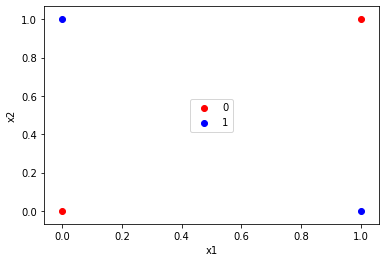

In [7]:
plt.scatter(X[y==0, 0], X[y==0, 1], c='red');
plt.scatter(X[y==1, 0], X[y==1, 1], c='blue');
plt.xlabel('x1');
plt.ylabel('x2');
plt.legend(['0', '1'], loc='center');

## Decision tree

Decision trees recursively partitions the feature space. The decisions are typically simple. Because of the recursive partitioning, the decision can be represented as a tree.

These techniques were originally created to display decisions in a human-redeable fashion. They are therefore easy to read and interpret.

For example, for the XOR problem, is very easy to create a decision tree that solves it with 100% accuracy.

In [8]:
def xor_decision_tree(x):
    x1, x2 = x
    if x1 == 0:
        if x2 == 0:
            return 0
        elif x2 == 1:
            return 1
    elif x1 == 1:
        if x2 == 0:
            return 1
        elif x2 == 1:
            return 0

In [9]:
# accuracy
(list(map(xor_decision_tree, X)) == y).mean()

1.0

### Types of decision trees

In mathematical terms, decision tress partition the feature space into, say, $M$ _regions_ $R_1, ..., R_M$. For each region, we build a prediction based on the training datapoints that fall into that region. 

#### Regression tree
For a regression problem and a region $m$, for example, we may predict that the region value is the mean of the points that belong to that region, denoted by $\bar{y}_{R_m}$. In this simple approach, we evaluate the performance of a regression tree by the squared error of the regression predictions

\begin{equation}
\sum_{m=1}^M \sum_{i\in R_m} (y_i - \bar{y}_{R_m})^2
\end{equation}

#### Classification tree

A similar approach is taken for classification trees, where the dependent variable $y$ is categorical. The classification trees predicts a class $k$ for region $m$ as the _most common training class_ occuring in that region.

To measure the performance of a classification tree, we often measure the proportion of training examples from class $k$ in region $m$, denoted as $\hat{p}_{mk}$. For a particular region, one performance measure is the Gini index

\begin{equation}
G_m = \sum_{k=1}^K \hat{p}_{mk} (1 - \hat{p}_{mk})
\end{equation}

Intuitively, the index is small when the values $\hat{p}_{mk}$ are close to zero or one.

Another measure of performance is cross entropy

\begin{equation}
D_m = - \sum_{k=1}^K \hat{p}_{mk} \text{log}(\hat{p}_{mk})
\end{equation}

Cross entropy is a mathematical tool which tells us the similarity between 2 probability distributions.  Distributions that are similar have a low cross entropy and distributions that are not similar have a high cross entropy.

At the end, we want to minimize either $\sum_m G_M$ or $\sum_m D_m$.

### Building a decision tree

The search of all possible recursive partitions is intractable. So typically the process is split into two steps.

1. Building. The tree is built from the top down (from one feature to all features) in a greedy fashion until some criteria is met.

    1. We start from a region that has every point
    1. We select a feature and a cutting point that splits a region so that the loss is minimized.
    1. We repeat recursively until a criteria, such as number of examples in a leaf, is met.

1. Pruning or regularization. Given a regularization parameter $\alpha$ and starting from the most complex tree found before, we find a new tree that optimizes the following loss function

\begin{equation}
\sum_{m=1}^M \sum_{x_i \in R_m} L(y_i, \hat{f}(x_i)) + \alpha M 
\end{equation}

where $L$ is the loss function either for a regression or classification problem. Since $M$ is the number regions, then $\alpha \mid M \mid$ acts as an $L1$ regularization.

# Problems with decision trees

In one word: __Overfitting__

Question: how many ways can we build a tree for the same dataset?

(from ISRL)

1. The good
    1. Trees are very easy to explain to people. In fact, they are even easier to explain than linear regression!
    1. Some people believe that decision trees more closely mirror human decision-making than do the regression and classification approaches seen in previous chapters.
    1. Trees can be displayed graphically, and are easily interpreted even by a non-expert (especially if they are small).
    1. Trees can easily handle qualitative predictors without the need to create dummy variables.

1. The bad
    1. Unfortunately, trees generally do not have the same level of predictive accuracy as some of the other regression and classification approaches seen in this book.
    1. Additionally, trees can be very non-robust. In other words, a small change in the data can cause a large change in the final estimated tree

# Bagging

The problem with decision trees and other learning methods is that they have _high variance_. If fit into two training set, they can produce very different fits.

One solution to this problem is to _average_ the opinions of several models fit to different training sets. Given that we usually don't have many training sets, we use a technique called _bootstrap_ to produce them. In boostrap, we generate _fictitious_ training sets by sampling the training set _with replacement_. We do this multiple times, fitting a model to each bootsrap sample, and predicting based on the average of the trees. This is called __bagging__ which is short for _bootstrap aggregation_.

## The wisdom of the crowds

Here is the intuition behind bagging. Image asking $B$ people the opinion about the height of someone. Assume that each person has a high variance $\sigma^2$ in their estimates and no biases. If we average the B opinions, what is the variance of the resulting estimate (hint:  See ISLR chapter8_trees.pdf slide number 31)?

In [10]:
import numpy as np

In [11]:
person_std = np.sqrt(10.)
n_simulations = 10000
crowd_size = 10
opinions = np.random.normal(scale=person_std, size = (n_simulations, crowd_size))
print("opinions.shape:", opinions.shape)

opinions.shape: (10000, 10)


In [12]:
# lets average crowd opinions
avg_opinions = opinions.mean(axis=1)
print("avg_opinions.shape:", avg_opinions.shape)

avg_opinions.shape: (10000,)


In the cell below, the average variance of the crowd is close to 1 but the variance of a person in the crowd was 10.

In [13]:
# let's look at the variance
np.var(avg_opinions)

1.0017253968630222

In [14]:
import matplotlib.pyplot as plt

The plot below shows an estimate of how the variance of the average opinion of the crowd is expected to decrease as the crowd size increases.  The plot starts with a variance of 10 (1 person crowd) and steadily decreases as we add people to the crowd and average the opionions of the people in the crowd.

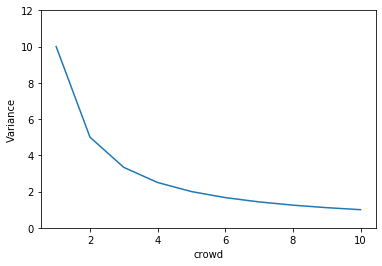

In [15]:
plt.plot(np.linspace(1, 10, num=10), 10/np.linspace(1, 10, num=10));
plt.xlabel('crowd');
plt.ylabel('Variance');
plt.ylim([0, 12]);

## Tree bagging

Similarly to the wisdom of the crowds, you can think of the statistical estimation of models and then bagging as a way of lowering the variance of models!

Therefore, if we fit ($\hat{f}^{*b}$) different decision trees to boostrapped version $b$ of the data, then we can average those results for regression:

\begin{equation}
\hat{f}_{\text{bagging}}(X) = \frac{1}{B} \sum_{b=1}^B  \hat{f}^{*b}(X)
\end{equation}

or in classification

\begin{equation}
\hat{f}_{\text{bagging}}(X) = \text{majority} \{\hat{f}^{*b}(X) \mid b \in \{1, \dots, B \} \}
\end{equation}

The problem with tree bagging is that it is harder to measure feature importance because we are now averaging the prediction of several trees.  One solution to this is to compute, across all trees, how much on average a feature decreases the loss function. We can then use that measure to sort features by importance.

One convenient by-product of bagging is that we can compute the validaton performance of our model by computing the performance of the fit in the _out of bag_ datapoints. This is, every time we sample with replacement from the data, there is a set of datapoints that is not used in the data.

The argument goes like this. A single point has a chance of $1/n$ of being sampled. This means that the probability of a point not being sampled during a bootstrap sample is $(1-\frac{1}{n})^n$. Taking the $\lim_{n\rightarrow \infty} (1-\frac{1}{n})^n = \frac{1}{e} \approx 36\% \approx \frac{1}{3}$. So, in boostrapped estimators an observation will not be included in the bootstrap sample approximately 1/3 of the time. 

In summary, the derivation above shows that when using boostrap sampling (sampling with replacement), approximately $1/3$ of the observations in the data being sampled will not make it into the resulting sample data set.  The samples that don't make it into the resulting sample data set are called _out of bag_ samples and can be used to determine testing performance.

### Limitations of the wisdom of the crowds

Now, the wisdom of the crowds assumes that opinions are independent, but boostrapping makes the trees dependent because we are resampling the same training data multiple times.

What is the effect of making opinions dependent?  The cell below creates a covariance matrix assuming a variance of 10 (10 on the diagonal) with each of the 1000 predictors correlated 90% to each other (9 everywhere except the diagonal).  Next, the covariance matrix is used to generate a 1000 x 1000 matrix of multivariate uniform random data.

In [16]:
# wisdom of the crowds with opinion correlation
corr = 0.9
B = 1000
cov = (np.ones((B, B)) * corr + np.eye(B)*(1-corr))*(person_std**2)
mu = np.zeros(B)
correlated_opinions = np.random.multivariate_normal(mu, cov, (n_simulations,))
print("correlated_opinions.shape", correlated_opinions.shape)

correlated_opinions.shape (10000, 1000)


In [17]:
correlated_opinions.mean(1).var()

9.023911155695751

With 90% correlation, the crowd doesn't do much better than individuals! In general, the variance of correlated opinions is:

\begin{equation}
\text{var}(f) = \bigl( \frac{1-\rho}{B} + \rho \bigr) \sigma^2
\end{equation}

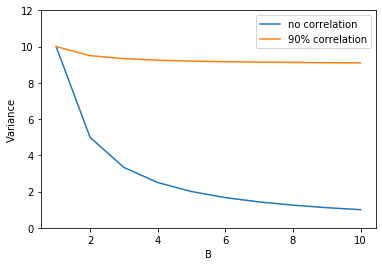

In [18]:
plt.clf();
pl1 = plt.plot(np.linspace(1, 10, num=10), 10/np.linspace(1, 10, num=10));
pl2 = plt.plot(np.linspace(1, 10, num=10), 10*((1-0.9)/np.linspace(1, 10, num=10) + 0.9));
plt.xlabel('B');
plt.ylabel('Variance');
plt.ylim([0, 12]);
plt.legend(['no correlation', '90% correlation']);

## Random forest

Random forest is a tweak to the boostrapped trees predictions that decorrelate trees. It does this by randomly sampling $m$ features during each split when bulding the tree. In this way, each of trees look at different features and become decorrelated. A typical value of $m = \sqrt{p}$, where $p$ is the total number of variables or columns.

## Gradient boosting

Boosting _grows_ a model. It first fits a simple model and the next model focuses on samples poorly fit by the previous model. It is a way of _adaptively_ fitting the data. In a sense, boosting does not resample the data. 

Boosting is a technique whose theoretical workings go outside of the scope of this course. Roughly speaking, however, while bagging aims at lowering the variance in the learning process, boosting aims at reducing the bias.

# Application in Spark

In [19]:
# dataframe functions
from pyspark.sql import functions as fn

In [20]:
import os

In [21]:
def get_training_dataframe():
    data_file_name = "cs-training.csv"
    
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if the databricks env var exists
    if db_env != None:
        full_path_name = "/FileStore/tables/%s" % data_file_name
    else:
        full_path_name = data_file_name
    
    return spark.read.csv(full_path_name, inferSchema=True, header=True)

In [22]:
# read the data file
from pyspark.sql.types import DoubleType

# read the training data .csv file
credit_score_df = get_training_dataframe()

# rename prediction col to 'label'
credit_score_df = credit_score_df.withColumnRenamed('SeriousDlqin2yrs', 'label')

# cast string cols to double
credit_score_df = credit_score_df.withColumn('NumberOfDependents', credit_score_df['NumberOfDependents'].cast(DoubleType()))
credit_score_df = credit_score_df.withColumn('MonthlyIncome', credit_score_df['MonthlyIncome'].cast(DoubleType()))

# drop NAs and nulls and remove index col
credit_score_df = credit_score_df.dropna().drop('_c0')

# display a sample of the data frame
display(credit_score_df.limit(10).toPandas())

,label,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
7,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0
8,0,0.644226,30,0,0.309476,2500.0,5,0,0,0,0.0
9,0,0.018798,51,0,0.531529,6501.0,7,0,2,0,2.0


The cell below shows the data dictionary for the data set.

| Variable Name                        | Description                                                                                                                                              | Type       |
|--------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|------------|
| SeriousDlqin2yrs                     | Person experienced 90 days past due delinquency or worse                                                                                                 | Y/N        |
| RevolvingUtilizationOfUnsecuredLines | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits | percentage |
| age                                  | Age of borrower in years                                                                                                                                 | integer    |
| NumberOfTime30-59DaysPastDueNotWorse | Number of times borrower has been 30-59 days past due but no worse in the last 2 years.                                                                  | integer    |
| DebtRatio                            | Monthly debt payments, alimony,living costs divided by monthy gross income                                                                               | percentage |
| MonthlyIncome                        | Monthly income                                                                                                                                           | real       |
| NumberOfOpenCreditLinesAndLoans      | Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)                                                     | integer    |
| NumberOfTimes90DaysLate              | Number of times borrower has been 90 days or more past due.                                                                                              | integer    |
| NumberRealEstateLoansOrLines         | Number of mortgage and real estate loans including home equity lines of credit                                                                           | integer    |
| NumberOfTime60-89DaysPastDueNotWorse | Number of times borrower has been 60-89 days past due but no worse in the last 2 years.                                                                  | integer    |
| NumberOfDependents                   | Number of dependents in family excluding themselves (spouse, children etc.)                                                                              | integer    |

We need to put the independent variables into one feature vector

In [23]:
from pyspark.ml.feature import VectorAssembler

In [24]:
training_df, validation_df, testing_df = credit_score_df.randomSplit([0.6, 0.3, 0.1])

In [25]:
# build a pipeline for analysis
va = VectorAssembler().setInputCols(training_df.columns[2:]).setOutputCol('features')

In [26]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

In [27]:
from pyspark.ml import Pipeline

In [28]:
lr = LogisticRegression(regParam=0.1)

In [29]:
lr_pipeline = Pipeline(stages=[va, lr]).fit(training_df)

In [30]:
rf = RandomForestClassifier()

In [31]:
rf_pipeline = Pipeline(stages=[va, rf]).fit(training_df)

In [32]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [33]:
bce = BinaryClassificationEvaluator()

In [34]:
bce.evaluate(lr_pipeline.transform(validation_df))

0.6662809618770269

In [35]:
bce.evaluate(rf_pipeline.transform(validation_df))

0.8105651391818619

Using default tuning parameters, Random Forest performs much better logistic regression!

# Try to interpret the results

## Logistic regression

In [36]:
lr_model = lr_pipeline.stages[-1]

In [37]:
import pandas as pd

In [38]:
pd.DataFrame(list(zip(credit_score_df.columns[2:], lr_model.coefficients.toArray())),
            columns = ['column', 'weight']).sort_values('weight')

,column,weight
0,age,-0.010054
4,NumberOfOpenCreditLinesAndLoans,-0.005205
2,DebtRatio,-0.000027
3,MonthlyIncome,-0.000003
7,NumberOfTime60-89DaysPastDueNotWorse,0.000648
6,NumberRealEstateLoansOrLines,0.009242
5,NumberOfTimes90DaysLate,0.014017
1,NumberOfTime30-59DaysPastDueNotWorse,0.022021
8,NumberOfDependents,0.046626


## Random forest

In [39]:
rf_model = rf_pipeline.stages[-1]

In [40]:
pd.DataFrame(list(zip(credit_score_df.columns[2:], rf_model.featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight')
#rf_model.featureImportances

,column,weight
8,NumberOfDependents,0.002589
6,NumberRealEstateLoansOrLines,0.006293
3,MonthlyIncome,0.010224
2,DebtRatio,0.013879
4,NumberOfOpenCreditLinesAndLoans,0.020535
0,age,0.024356
1,NumberOfTime30-59DaysPastDueNotWorse,0.194697
7,NumberOfTime60-89DaysPastDueNotWorse,0.239896
5,NumberOfTimes90DaysLate,0.487531


Let's take a look at one tree

In [41]:
len(rf_model.trees)

20

In [42]:
print(rf_model.trees[0].toDebugString)

DecisionTreeClassificationModel (uid=dtc_adf5108f670f) of depth 5 with 41 nodes
  If (feature 1 <= 0.5)
   If (feature 7 <= 0.5)
    If (feature 5 <= 0.5)
     Predict: 0.0
    Else (feature 5 > 0.5)
     If (feature 5 <= 1.5)
      Predict: 0.0
     Else (feature 5 > 1.5)
      If (feature 3 <= 8321.0)
       Predict: 1.0
      Else (feature 3 > 8321.0)
       Predict: 0.0
   Else (feature 7 > 0.5)
    If (feature 3 <= 3957.5)
     If (feature 5 <= 0.5)
      Predict: 0.0
     Else (feature 5 > 0.5)
      If (feature 0 <= 31.5)
       Predict: 0.0
      Else (feature 0 > 31.5)
       Predict: 1.0
    Else (feature 3 > 3957.5)
     If (feature 7 <= 1.5)
      Predict: 0.0
     Else (feature 7 > 1.5)
      If (feature 5 <= 0.5)
       Predict: 0.0
      Else (feature 5 > 0.5)
       Predict: 1.0
  Else (feature 1 > 0.5)
   If (feature 5 <= 0.5)
    If (feature 7 <= 0.5)
     Predict: 0.0
    Else (feature 7 > 0.5)
     If (feature 0 <= 31.5)
      If (feature 8 <= 2.5)
       Predict: 0

In [43]:
gbt = GBTClassifier()
gbt_pipeline = Pipeline(stages=[va, gbt]).fit(training_df)

In [44]:
bce.evaluate(gbt_pipeline.transform(validation_df))

0.8206403058786949